# <center>UE 4.1 - Machine Learning </center>

UE 4.1 Machine Learning
Noms et prénoms : Maïsani Cyril, Le Pennec Goulven


In [79]:
import numpy as np
import sklearn as sk
import os
import cv2
from matplotlib import pyplot as plt
import skimage
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.transform import warp_polar, rotate, rescale
from skimage.util import img_as_float
from sklearn.neighbors import KNeighborsClassifier
import random

path = "./pythonProject/images_ISAR"

---

## Partie I - Analyse de données ISAR

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Généralités sur la base de données</h3>

#### Lecture du fichier
Premièrement, on load le fichier zip contenant les images.

810


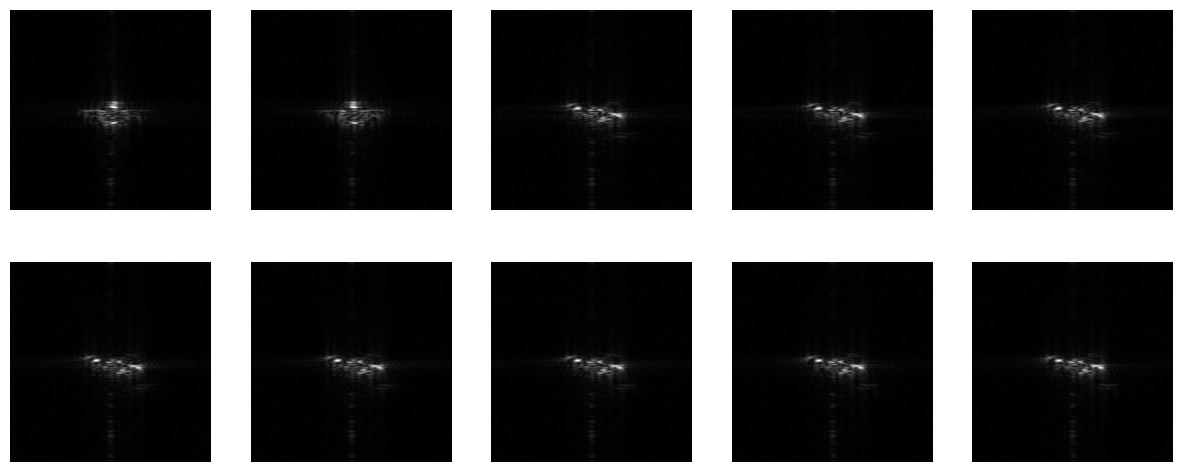

In [80]:

def get_matrice_de_donnees(path):
    images = []
    for image in os.listdir(path):
        img = cv2.imread(os.path.join(path,image),cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

images = get_matrice_de_donnees(path)
print(len(images))

##Affichage de 10 d'entre elles
def aff(images):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(images[i*5+j], cmap='gray')
            axs[i, j].axis('off')
    plt.show()

aff(images[:10])

Il y a 810 images dans le dossier "images_ISAR".

#### Séparation des images par classes

In [81]:
# Store the image file names in a list as long as they are bmps
nom_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.bmp']
type_appareil=[]
for k in nom_images:
    type_appareil.append(k.split("_")[0])  #split the names before the _

#print(type_appareil)
values, counts = np.unique(type_appareil, return_counts=True)  #count the number of different elements in the list

print(values,counts)

['A10' 'F14' 'F15' 'F16' 'F4'] [162 162 162 162 162]


#### Histogramme

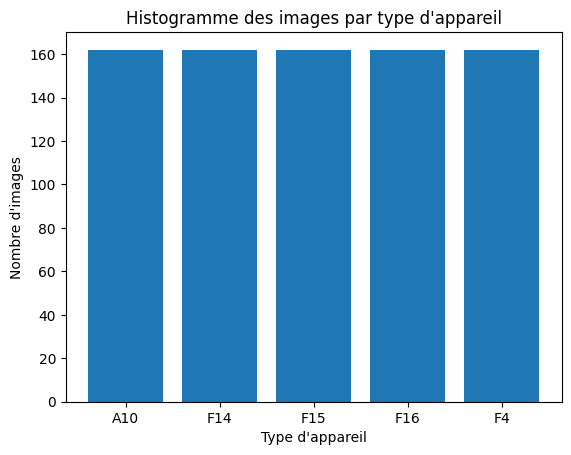

Nombre d'images par classe :  [162 162 162 162 162]
Nombre de classes :  5


In [82]:
# Histogramme

plt.bar(values, counts)
plt.xlabel('Type d\'appareil')
plt.ylabel('Nombre d\'images')
plt.title('Histogramme des images par type d\'appareil')
plt.show()

print("Nombre d'images par classe : ", counts)
print("Nombre de classes : ", len(values))



#### Dimension de l'espace de données

Commentaires : Les données sont réparties de façon hommogènes et il y a un nombre significatif d'images par classe'

In [83]:
# Dimension de l'espace de données

print("Dimension de l'espace de données : ", images[0].shape)

# Valeur min et max :

print("Valeur min : ", np.min(images))
print("Valeur max : ", np.max(images))

Dimension de l'espace de données :  (256, 256)
Valeur min :  0
Valeur max :  255


#### Réduction de la dimension des données



##### Affichage des niveaux de gris d'une image aléatoire

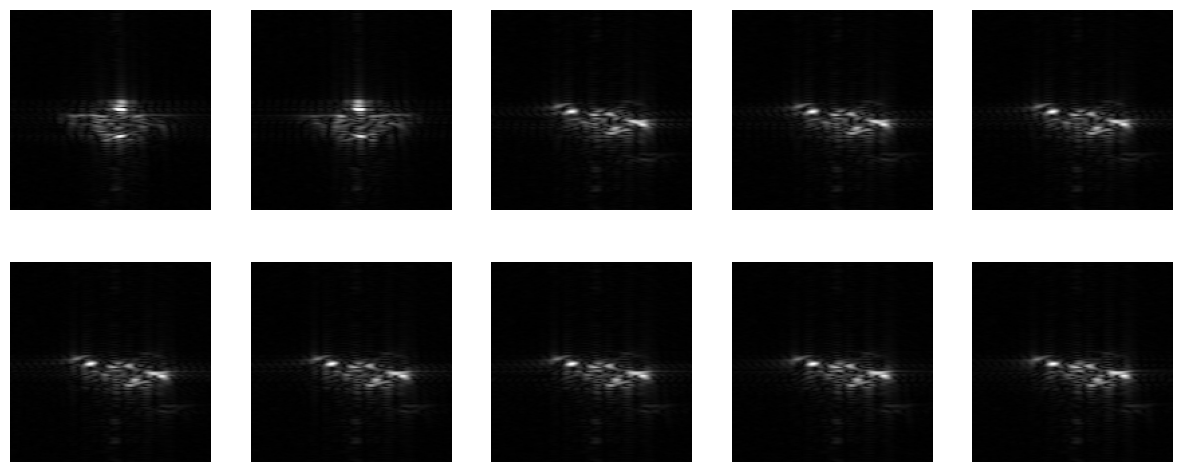

Dimension de l'espace de données après découpage :  (150, 150)


In [84]:
def crop(a):
    new=[]
    for i in range(len(a)):
        new.append(a[i][50:200,50:200])
    return new

images = crop(images)


##Affichage après découpage

aff(images)
print("Dimension de l'espace de données après découpage : ", images[0].shape)

Le gain est de 256 - 150 = 106 pixels par image.

<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Load BDD</h3>

Ici, on a une fonction qui à partir d'un dossier donné d'images (de format .bmp) renvoie la matrice des donneés et le vecteur des labels

In [85]:
def get_vecteur_label(path):
    nom_images = [f for f in os.listdir(path) if os.path.splitext(f)[-1] == '.bmp']
    type_appareil=[]
    for k in nom_images:
        type_appareil.append(k.split("_")[0])  #split the names before the _
    return type_appareil


def load_bdd(path):
    #On charge la matrice des données
    images = get_matrice_de_donnees(path)
    images = crop(images) # On crop les images
    for image in images:
        image = np.reshape(image, (image.shape[0] * image.shape[1], 1)) # Verticalisation des images
    vecteur_label = get_vecteur_label(path) # On charge les labels
    
    return images, vecteur_label

images, vecteur_label = load_bdd(path) # On charge les données

## Partie II - Extraction des caractéristiques discriminantes – Image polaire

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Fonction polaire()</h3>

In [86]:
#Image aléatoire

image = images[random.randint(0, len(images)-1)] # On prend une image aléatoire parmis toutes les images

# exemple de la fonction polaire
def polaire(image, Nr=50, Mtheta=50, Rmax=50):
    M, N = image.shape
    center_x, center_y = N//2, M//2
    polar_image = np.zeros((Nr, Mtheta))
    dtheta = 2*np.pi/(Mtheta-1)
    dr = Rmax/(Nr-1)
    for m in range(Nr):
        for n in range(Mtheta):
            theta = -np.pi + (n-1)*dtheta
            r = (m-1)*dr
            x = center_x + r*np.cos(theta)
            y = center_y + r*np.sin(theta)
            x, y = int(x), int(y)
            if x >= N or y >= M:
                continue
            polar_image[m,n] = image[x, y]

    return polar_image

# La dimension de l'image polaire :
polar_image = polaire(image)
print("Dimension de l'image polaire : ", polar_image.shape)

# Dimension de l'espace de représentation polaire :

# Comme l'image est de taille 50x50, la dimension de l'espace de représentation est 2.


    


Dimension de l'image polaire :  (50, 50)


<div class="alert alert-info">
<h3 class="alert-heading"> Question 2 - Invariances des images polaires</h3>

### Invariance par rotation

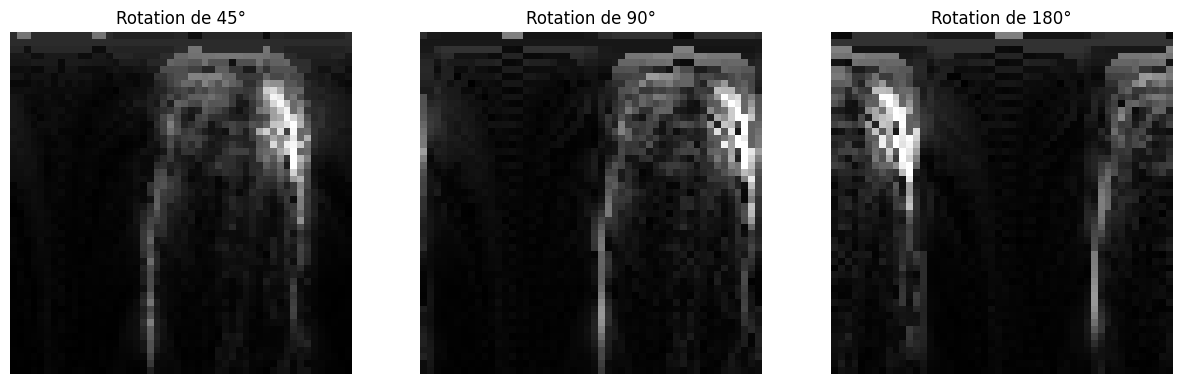

In [103]:
# Rotation de 45°
angle = 45
rot_image_45 = rotate(image, angle)
polar_image_45 = polaire(rot_image_45)

# Rotation de 90°

angle = 90
rot_image_90 = rotate(image, angle)
polar_image_90 = polaire(rot_image_90)

# Rotation de 180°

angle = 180
rot_image_180 = rotate(image, angle)
polar_image_180 = polaire(rot_image_180)

# Affichage des images polaires après rotation

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(polar_image_45, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Rotation de 45°')
axs[1].imshow(polar_image_90, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Rotation de 90°')
axs[2].imshow(polar_image_180, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Rotation de 180°')
plt.show()


Les images polaires ne sont pas invariants par rotation. En effet, on observe que les images polaires sont différentes après rotation.

### Invariance par changement d'échelle

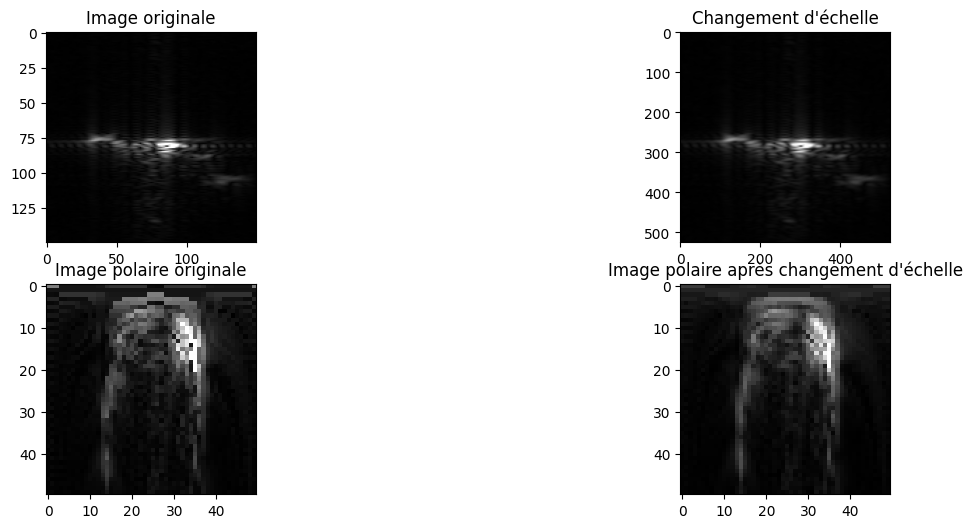

In [99]:
# Changement d'échelle: scale = 3.5
def aff_change_scale(image, scale):
    
    rescaled_image = rescale(image, scale)
    rescaled_polar_image = polaire(rescaled_image, 50, 50, 180)
    
    # Affichage des images polaires après changement d'échelle
    
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Image originale')
    plt.subplot(2, 2, 2)
    plt.imshow(rescaled_image, cmap='gray')
    plt.title('Changement d\'échelle')
    plt.subplot(2, 2, 3)
    plt.imshow(polar_image, cmap='gray')
    plt.title('Image polaire originale')
    plt.subplot(2, 2, 4)
    plt.imshow(rescaled_polar_image, cmap='gray')
    plt.title('Image polaire après changement d\'échelle')
    plt.show()

scale = 3.5
aff_change_scale(image, scale)


Plus le Rmax augmente et plus l'image polaire est invariante par changement d'échelle.

### Invariance par changement d'échelle et translation

In [89]:
#Changement d'échelle: scale = 3.5


L'image obtenue est de taille (50x50).

<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Nouveau vecteurs caractéristiques: $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ </h3>

In [120]:
def polaire1(image, Nr=50, Mtheta=50, Rmax=50):
    """Exécute la fonction polaire en renvoyant également les vecteurs I_theta et I_r"""
    polare_image = polaire(image, Nr, Mtheta, Rmax)
    polare_image /= np.max(polare_image)
    Itheta = np.sum(polare_image, axis=0)
    Ir = np.sum(polare_image, axis=1)

    return polar_image, Ir, Itheta

Commençons pas regarder le résultats des vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ sur un image aléatoire.

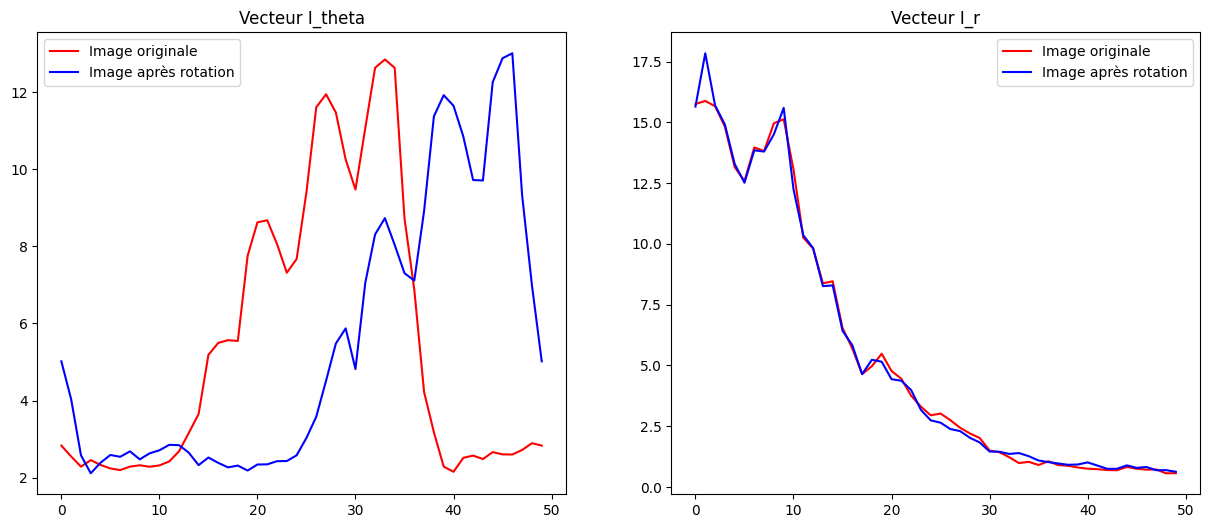

In [132]:
image = images[random.randint(0, len(images)-1)] # On prend une image aléatoire parmis toutes les images
polar_image, Ir, Itheta = polaire1(image)
rot_image = rotate(image, 90)
polar_image_rot, Ir_rot, Itheta_rot = polaire1(rot_image)
# Affichage des vecteurs I_theta et I_r

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].plot(Itheta, color='red')
axs[0].plot(Itheta_rot, color='b')
axs[0].set_title('Vecteur I_theta')
axs[1].plot(Ir, color='r')
axs[1].plot(Ir_rot, color='b')
axs[1].set_title('Vecteur I_r')
axs[0].legend(['Image originale', 'Image après rotation'])
axs[1].legend(['Image originale', 'Image après rotation'])
plt.show()

On observe que les vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ sont similaires après les transformation de rotation lorsqu'on a normalisé l'image polaire.

Si l'image n'est pas normalisée, les vecteurs restent similaires mais ne sont pas à la même échelle.

<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Invariances des vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$</h3>

### Invariance par rotation et changement d'échelle

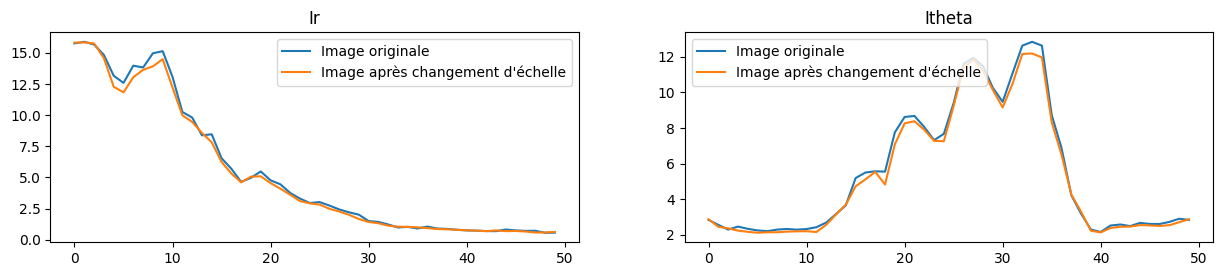

In [140]:
#Changement d'échelle: scale = 3.5

def aff_change_scale1(image, scale):

    rescaled_image = rescale(image, scale)
    rescaled_polar_image, Ir_res, Itheta_res = polaire1(rescaled_image, 50, 50, 180)
    
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 2, 1)
    plt.plot(Ir)
    plt.plot(Ir_res)
    plt.title('Ir')
    plt.legend(['Image originale', 'Image après changement d\'échelle'])
    plt.subplot(2, 2, 2)
    plt.plot(Itheta)
    plt.plot(Itheta_res)
    plt.title('Itheta')
    plt.legend(['Image originale', 'Image après changement d\'échelle'])
    plt.show()

scale = 3.5
aff_change_scale1(image, scale)


On observe que les vecteurs $\mathbf{I}_{\text{\theta}}$ et $\mathbf{I}_{\text{r}}$ sont les très similaires (au changement d'échelle près) après les transformation.



### Mesure de distances eucliennes

#### Cross-correlation pour la rotation

Pour une multitude d'angle, nous allons calculer le $\mathbf{I}_{\text{\theta}}$ et calculer la correlation. Ainsi, on pourra tracer la courbe de corrélation en fonction de ${\theta}$.


In [91]:

    corr = np.corrcoef(Itheta, Itheta_rot)[0,1]
    corr = np.abs(corr)
    C.append(corr)

    # Trouver le shift correspondant à la meilleure correspondance
    shift = np.abs(np.argmin(Itheta)-np.argmin(Itheta_rot))
    S.append(shift)



NameError: name 'Itheta' is not defined

---

## Partie III - Classification

<div class="alert alert-info">
<h3 class="alert-heading"> Question 1 - Descripteur</h3>

#### Matrice data




<div class="alert alert-info">
<h3 class="alert-heading"> Question 3 - Classifieur C1</h3>

In [ ]:
def classifieurC1_Itheta(BA,BT,n_neigh):

    return




In [ ]:
def classifieurC1_II(BA,BT,n_neigh):


<div class="alert alert-info">
<h3 class="alert-heading"> Question 5 - Classifieur C2 </h3>

<div class="alert alert-info">
<h3 class="alert-heading"> Question 6 - Rotation et changement d'échelle </h3>